In [5]:
# !pip install PrettyPrintTree
import pandas as pd
import time
import warnings
import pickle as pkl
from gosdt import GOSDTClassifier
from gosdt._tree import Node, Leaf
import treefarms
from treefarms import TREEFARMS
import numpy as np
from tqdm import tqdm
from copy import deepcopy
import gosdt
from helper_functions_treefarms_lookahead import are_trees_same, get_num_leaves_greedy, get_num_leaves_gosdt, _tree_to_dict
dataset = 'netherlands'
warnings.filterwarnings("ignore")
df = pd.read_csv("{}_binary_aggressive.csv".format(dataset))

X, y = df.iloc[:, :-1], df.iloc[:, -1]
h = df.columns[:-1]  # header

## Main TreeFARMS Lookahead class

In [41]:
import builtins
import sys


class TreeFARMSLookahead(treefarms.model.treefarms.TREEFARMS):
    def __init__(self, config, load_path=False, fill_greedy=False):
        self.config = config
        self.load_path = load_path
        if not self.load_path:
            self.rashomon_set_prefix = TREEFARMS(config)
        else:
            self.rashomon_set_prefix = pkl.load(open(load_path, 'rb'))['rset']
        self.fill_greedy = fill_greedy
        self.models = []
        self.num_models = 0
        self.num_models_per_prefix = []

    def fit(self, X, y):
        self.n = X.shape[0]

        if not self.load_path:
            self.rashomon_set_prefix.fit(X, y)

        self.remaining_depth = self.config['depth_budget'] - \
            self.config['cart_lookahead_depth']+1

        for i in tqdm(range(self.rashomon_set_prefix.get_tree_count())):
            tree_dict = vars(self.rashomon_set_prefix[i])['source']
            tree = self.dict_to_tree(tree_dict, X, y)
            if self.fill_greedy:
                tree = self.fill_leaves_with_greedy(tree, X, y)
                tree_pred = np.array([self._predict_sample(
                    X.values[i, :], tree) for i in range(X.shape[0])])
                tree_loss = (y != tree_pred).mean()
                tree_leaves = get_num_leaves_greedy(tree)
                obj = tree_loss + self.config['regularization']*tree_leaves
                self.models.append(tree)
            else:
                start_time = time.time()
                trees = self.fill_leaves_with_treefarms(tree, X, y)
                end_time = time.time()
                print("Time taken to fill leaves with treefarms: ",
                      end_time-start_time)
                # start_time = time.time()
                num_models, trees = self.enumerate_treefarms_subtrees(
                    deepcopy(trees))
                self.num_models += num_models
                self.num_models_per_prefix.append(num_models)
                # end_time = time.time()
                self.models.append(trees)

    def __len__(self):
        if self.fill_greedy:
            return len(self.models)
        else:
            return self.num_models

    def __getitem__(self, idx):
        # find the appropriate prefix
        if not self.fill_greedy:
            counter = 0
            num_trees = 0
            while num_trees <= idx and counter < len(self.models):
                num_trees += self.num_models_per_prefix[counter]
                counter += 1
            num_trees -= self.num_models_per_prefix[counter-1]
            return self.get_leaf_subtree_at_idx(self.models[counter-1], idx-num_trees)
        else:
            return self.models[idx]

    def get_leaf_subtree_at_idx(self, prefix_trie, idx):

        if isinstance(prefix_trie, Leaf):
            return prefix_trie

        if isinstance(prefix_trie, list):
            return prefix_trie[idx]

        tree = Node(feature=int(prefix_trie.feature),
                    left_child=None, right_child=None)
        left_count = prefix_trie.left_child[1]
        right_count = prefix_trie.right_child[1]
        right_idx = idx % right_count
        left_idx = idx//right_count
        tree.left_child = self.get_leaf_subtree_at_idx(
            deepcopy(prefix_trie.left_child[0]), left_idx)
        tree.right_child = self.get_leaf_subtree_at_idx(
            deepcopy(prefix_trie.right_child[0]), right_idx)
        return tree

    def enumerate_treefarms_subtrees(self, tree):
        """
        Returns a list of all possible tree structures induced by the cross
        product of subtree candidates in node.left_child and node.right_child.
        """

        # 1. Base cases
        if tree is None:
            return 1

        if isinstance(tree, list):  # list of subtrees rooted at the leaf of the prefix tree
            return len(tree), tree

        left_expansions, left_subtree = self.enumerate_treefarms_subtrees(
            tree.left_child)
        tree.left_child = (left_subtree, left_expansions)
        right_expansions, right_subtree = self.enumerate_treefarms_subtrees(
            tree.right_child)
        tree.right_child = (right_subtree, right_expansions)
        return left_expansions * right_expansions, tree

    def train_treefarms(self, X, y, depth_budget, reg, rashomon_bound_multiplier):
        """
        Train a TREEFARMS model on the given dataset. Output a list of trees as GOSDT Node objects
        """

        config = {'depth_budget': depth_budget, 'regularization': reg,
                  'rashomon_bound_multiplier': rashomon_bound_multiplier}
        model = TREEFARMS(config)
        model.fit(X, y)

        num_trees = model.get_tree_count()
        trees = []
        for i in range(num_trees):
            tree_dict = vars(model[i])['source']
            tree = self.dict_to_tree(tree_dict, X, y)
            trees.append(tree)
        return trees

    def fill_leaves_with_treefarms(self, tree, X, y):
        """
        Fill the leaves of a prefix-tree with TREEFARMS models. 
        I.e. for a current leaf, the parent node in the prefix tree now points to the list of trees output by the train_treefarms function above
        """

        if isinstance(tree, Leaf):
            # compute rashomon bound multiplier
            # leaf_config = {
            #     "regularization": min(0.1, self.config['regularization']*self.n/len(y)),
            #     "depth_budget": self.remaining_depth,
            #     "time_limit": 10,
            #     "similar_support": False,
            #     "verbose": False,
            #     'allow_small_reg': False,
            # }
            # greedy_tree, _ = self.train_greedy(
            #     X, y, leaf_config["depth_budget"], leaf_config['regularization'])
            # greedy_preds = np.array([self._predict_sample(X.values[i, :], greedy_tree)
            #                          for i in range(X.shape[0])])
            # greedy_leaves = get_num_leaves_greedy(greedy_tree)
            # greedy_loss = (y != greedy_preds).mean() + \
            #     leaf_config['regularization']*greedy_leaves
            # optimal_tree = GOSDTClassifier(**leaf_config)
            # optimal_tree.fit(X, y)
            # optimal_loss = (y != optimal_tree.predict(X)).mean(
            # ) + leaf_config['regularization']*get_num_leaves_gosdt(optimal_tree)
            rashomon_bound = 0.015

            # rashomon_bound = min(
            #     0.01, max(0, (greedy_loss - optimal_loss)/optimal_loss))
            # print("remaining depth: ", self.remaining_depth, min(
            #     0.1, self.config['regularization']*self.n/len(y)), rashomon_bound)
            if rashomon_bound == 0:
                node = [tree]
                return node
            else:
                model = self.train_treefarms(
                    X, y, self.remaining_depth, min(0.1, self.config['regularization']*self.n/len(y)), rashomon_bound)
                return model
        else:
            X_left = X[X.iloc[:, tree.feature] == True]
            y_left = y[X.iloc[:, tree.feature] == True]
            X_right = X[X.iloc[:, tree.feature] == False]
            y_right = y[X.iloc[:, tree.feature] == False]
            tree.left_child = self.fill_leaves_with_treefarms(
                tree.left_child, X_left, y_left)
            tree.right_child = self.fill_leaves_with_treefarms(
                tree.right_child, X_right, y_right)
        return tree

    def fill_leaves_with_greedy(self, tree, X, y):
        """
        Complete a given prefix tree output by treefarms greedily
        """
        if isinstance(tree, Leaf):
            node, loss = self.train_greedy(
                X, y, self.remaining_depth, self.config['regularization'])
            return node
        else:
            X_left = X[X.iloc[:, tree.feature] == True]
            y_left = y[X.iloc[:, tree.feature] == True]
            X_right = X[X.iloc[:, tree.feature] == False]
            y_right = y[X.iloc[:, tree.feature] == False]
            tree.left_child = self.fill_leaves_with_greedy(
                tree.left_child, X_left, y_left)
            tree.right_child = self.fill_leaves_with_greedy(
                tree.right_child, X_right, y_right)
        return tree

    def train_greedy(self, X, y, depth_budget, reg):

        node = Node(feature=None, left_child=None, right_child=None)

        # take majority label
        flag = True
        if len(y) > 0:
            y_pred = int(y.mean() > 0.5)
            loss = (y_pred != y).sum()/self.n + reg
        else:
            loss = 0
            y_pred = 0
            flag = False

        if depth_budget > 1 and flag:
            best_feature = self.find_best_feature_to_split_on(X, y)
            X_left = X[X.iloc[:, best_feature] == True]
            y_left = y[X.iloc[:, best_feature] == True]

            X_right = X[X.iloc[:, best_feature] == False]
            y_right = y[X.iloc[:, best_feature] == False]

            if len(X_left) != 0 and len(X_right) != 0:
                reg_left = reg*len(y)/(len(y_left))  # option to add this
                reg_right = reg*len(y)/(len(y_right))

                left_node, left_loss = self.train_greedy(
                    X_left, y_left, depth_budget-1, reg)
                right_node, right_loss = self.train_greedy(
                    X_right, y_right, depth_budget-1, reg)
                if left_loss + right_loss < loss:  # only split if it improves the loss
                    loss = left_loss + right_loss
                    node.left_child = left_node
                    node.right_child = right_node
                    node.feature = best_feature
                else:
                    node = Leaf(prediction=y_pred, loss=loss-reg)
            else:
                node = Leaf(prediction=y_pred, loss=loss-reg)
        else:
            node = Leaf(prediction=y_pred, loss=loss-reg)

        return node, loss

    def _predict_sample(self, x_i, node):
        if isinstance(node, Leaf):
            return node.prediction
        elif x_i[node.feature]:
            return self._predict_sample(x_i, node.left_child)
        else:
            return self._predict_sample(x_i, node.right_child)

    def predict(self, X_test, idx):
        X_values = X_test.values
        return np.array([self._predict_sample(X_values[i, :], self.models[idx])
                         for i in range(X_values.shape[0])])

    def dict_to_tree(self, tree_dict, X, y):
        # Base case: if the dictionary represents a prediction, return a Leaf object
        if "prediction" in tree_dict:
            return Leaf(prediction=tree_dict["prediction"], loss=(y != int(tree_dict["prediction"])).sum()/self.n)

        # Recursive case: construct a Node object
        # Recursively build the true and false branches
        left_child = self.dict_to_tree(
            tree_dict["true"], X[X.iloc[:, tree_dict["feature"]] == 1], y[X.iloc[:, tree_dict["feature"]] == 1])
        right_child = self.dict_to_tree(
            tree_dict["false"], X[X.iloc[:, tree_dict["feature"]] == 0], y[X.iloc[:, tree_dict["feature"]] == 0])
        node = Node(feature=tree_dict["feature"],
                    left_child=left_child, right_child=right_child)

        return node

    def entropy(self, ps):
        """
        Calculate the entropy of a given list of binary labels.
        """
        p_positive = ps[0]
        if p_positive == 0 or p_positive == 1:
            return 0  # Entropy is 0 if all labels are the same
        entropy_val = - (p_positive * np.log2(p_positive) +
                         (1 - p_positive) * np.log2(1 - p_positive))
        return entropy_val

    def find_best_feature_to_split_on(self, X, y):
        num_features = X.shape[1]
        max_gain = -10
        gain_of_feature_to_split = 0
        p_original = np.mean(y)
        entropy_original = self.entropy([p_original, 1-p_original])
        best_feature = -1
        for feature in range(num_features):
            # Left child labels
            p_left = np.mean(y[X.iloc[:, feature] == 1])

            # Right child labels
            p_right = np.mean(y[X.iloc[:, feature] == 0])

            p_left = 0 if np.isnan(p_left) else p_left
            p_right = 0 if np.isnan(p_right) else p_right

            entropy_left = self.entropy(np.array([p_left, 1 - p_left]))

            entropy_right = self.entropy(np.array([p_right, 1 - p_right]))

            proportion_of_examples_in_left_leaf = (
                np.sum(X.iloc[:, feature] == 1) / len(X))
            proportion_of_examples_in_right_leaf = (
                np.sum(X.iloc[:, feature] == 0) / len(X))
            gain = entropy_original - (proportion_of_examples_in_left_leaf * entropy_left +
                                       proportion_of_examples_in_right_leaf * entropy_right)
            if gain >= max_gain:
                max_gain = gain
                best_feature = feature

        return best_feature


# Save the original print function if you might want to restore it later
# original_print = builtins.print

# # Replace the built-in print with a no-op (does nothing)
# builtins.print = lambda *args, **kwargs: None

## Running TreeFARMS and TreeFARMS Lookahead

In [42]:
# Takes ~20-30s to run
lookahead = 2
config = {
    "regularization": 0.005,
    "rashomon_bound_multiplier": 0.01,
    "depth_budget": 5,
    'cart_lookahead_depth': lookahead,
    "verbose": False
}
start_time = time.time()
model = TreeFARMSLookahead(
    config, load_path='{}_model_lookahead_3.pkl'.format(dataset), fill_greedy=False)  # can set fill_greedy to True or False and investigate both cases
model.fit(X, y)
end_time = time.time()
lookahead_time = end_time-start_time + \
    pkl.load(open(model.load_path, 'rb'))['runtime']
print("Lookahead time: ", lookahead_time)

full_rashomon_set = pkl.load(
    open('{}_model_lookahead_0.pkl'.format(dataset), 'rb'))['rset']
fullrset_time = pkl.load(
    open('{}_model_lookahead_0.pkl'.format(dataset), 'rb'))['runtime']

# config = {
#     "regularization": 0.005,
#     "rashomon_bound_multiplier": 0.01,
#     "depth_budget": 5,
#     "verbose": False,
#     "time_limit": 600
# }

# start_time = time.time()
# full_rashomon_set = TREEFARMS(config)
# full_rashomon_set.fit(X, y)
# end_time = time.time()
# fullrset_time = end_time-start_time
# print("Full time: ", fullrset_time)

100%|██████████| 12/12 [00:05<00:00,  2.21it/s]


In [43]:
print(fullrset_time, lookahead_time)
# print(model[23])
t = model.dict_to_tree(vars(model.rashomon_set_prefix[0])['source'], X, y)
# print(len(model.models))
print(len(model), t)
for i in range(len(model)):
    print(i, model[i])

## Showing all trees in original and lookahead Rashomon set which have the same performance (case study for bug). 

In [44]:
full_rashomon_set_trees = []
losses_actual_rset = []
best_trees = []
for i in tqdm(range(full_rashomon_set.get_tree_count())):
    # converting dictionary to GOSDT Node object
    tree = model.dict_to_tree(vars(full_rashomon_set[i])['source'], X, y)
    full_rashomon_set_trees.append(tree)
    tree_preds = np.array([model._predict_sample(
        X.values[i, :], tree) for i in range(X.shape[0])])
    tree_leaves = get_num_leaves_greedy(tree)
    loss = (y != tree_preds).mean() + config['regularization']*tree_leaves
    # if loss < 0.3448 and loss > 0.3444:  # hard coded to show bug
    best_trees.append(tree)
    losses_actual_rset.append(float(loss))

losses_lookahead = []
best_trees_lookahead = []

# trees are already represented as GOSDT Node objects
for i in tqdm(range(len(model))):
    tree = model[i]
    tree_preds = np.array([model._predict_sample(
        X.values[i, :], tree)for i in range(X.shape[0])])
    tree_leaves = get_num_leaves_greedy(tree)
    loss = (y != tree_preds).mean() + config['regularization']*tree_leaves
    # if loss < 0.3448 and loss > 0.3444:  # hard coded to show bug
    best_trees_lookahead.append(tree)
    losses_lookahead.append(float(loss))

100%|██████████| 51/51 [00:02<00:00, 17.08it/s]


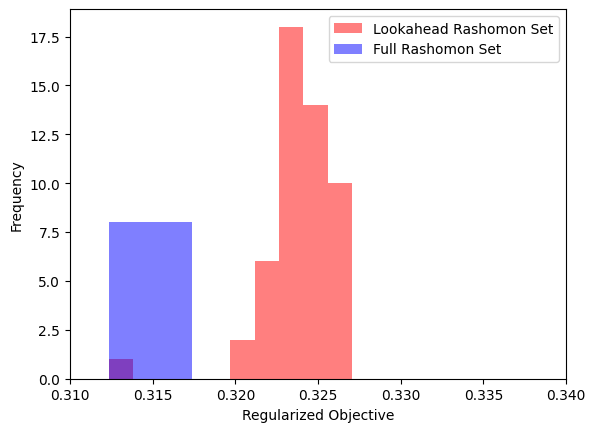

In [45]:
import matplotlib.pyplot as plt
plt.hist(losses_lookahead, color='r', alpha=0.5)
plt.hist(losses_actual_rset, color='b', alpha=0.5, bins=200)
plt.xlim(0.31, 0.34)
# plt.hist(losses_same,color='g',alpha=0.5)
plt.legend(['Lookahead Rashomon Set', 'Full Rashomon Set', 'Overlap'])
plt.xlabel("Regularized Objective")
plt.ylabel("Frequency")

print(losses_actual_rset)
# The histogram shows that there are more trees with this objective in the lookahead rashomon set than in the full rashomon set. This should not be possible

## Pretty print trees that have the same objective value in the original and lookahead Rashomon set.

In [46]:
from PrettyPrint import PrettyPrintTree
import matplotlib.pyplot as plt
import re
print(len(best_trees), len(best_trees_lookahead))


class TreeforPrettyPrinting:  # Printing Tree in an understandable format
    def __init__(self, value):
        self.val = value
        self.children = []

    def add_child(self, child):
        self.children.append(child)
        return child


def json_to_tree(json_obj, parent_label=""):
    if isinstance(json_obj, dict):
        if "prediction" in json_obj:
            # Base case: prediction node
            node = TreeforPrettyPrinting(
                f"Prediction: {json_obj['prediction']}")
        else:
            # Create a node with the feature
            node = TreeforPrettyPrinting(
                f"Feature: {json_obj.get('feature', parent_label)}")
            # Recursively add children for "True" and "False" branches
            for key, value in json_obj.items():
                if key not in ["feature", "prediction"]:
                    child = json_to_tree(value, parent_label=key)
                    node.add_child(TreeforPrettyPrinting(key).add_child(child))
    else:
        # If the JSON is a simple value, wrap it in a node
        node = TreeforPrettyPrinting(str(json_obj))
    return node


def plot_trees_in_subplots(trees, rows, cols):
    """
    Visualize multiple trees using PrettyPrintTree in subplots.
    """
    if rows == 4:
        fig, axes = plt.subplots(rows, cols, figsize=(20, 8))
    else:
        fig, axes = plt.subplots(rows, cols, figsize=(20, 15))
    axes = axes.flatten()

    pt = PrettyPrintTree(lambda x: x.children, lambda x: x.val)

    for i, tree in enumerate(trees):
        ax = axes[i]
        ax.axis("off")  # Turn off axis

        # Capture PrettyPrintTree output
        from io import StringIO
        import sys

        buffer = StringIO()
        sys.stdout = buffer
        pt(tree)
        sys.stdout = sys.__stdout__

        tree_output = buffer.getvalue()
        # strip [100m from tree output
        tree_output = tree_output.replace("\033[100m", "")
        tree_output = tree_output.replace("\033[0m", "")
        # Add bold formatting for digits

        # Render styled text in the plot
        ax.text(0.5, 0.5, tree_output, ha="center",
                va="center", fontsize=10, family="monospace")

    # Hide any unused subplots
    for ax in axes[len(trees):]:
        ax.axis("off")

    plt.tight_layout()
    # plt.subplots_adjust(hspace=50, wspace=50)
    plt.show()

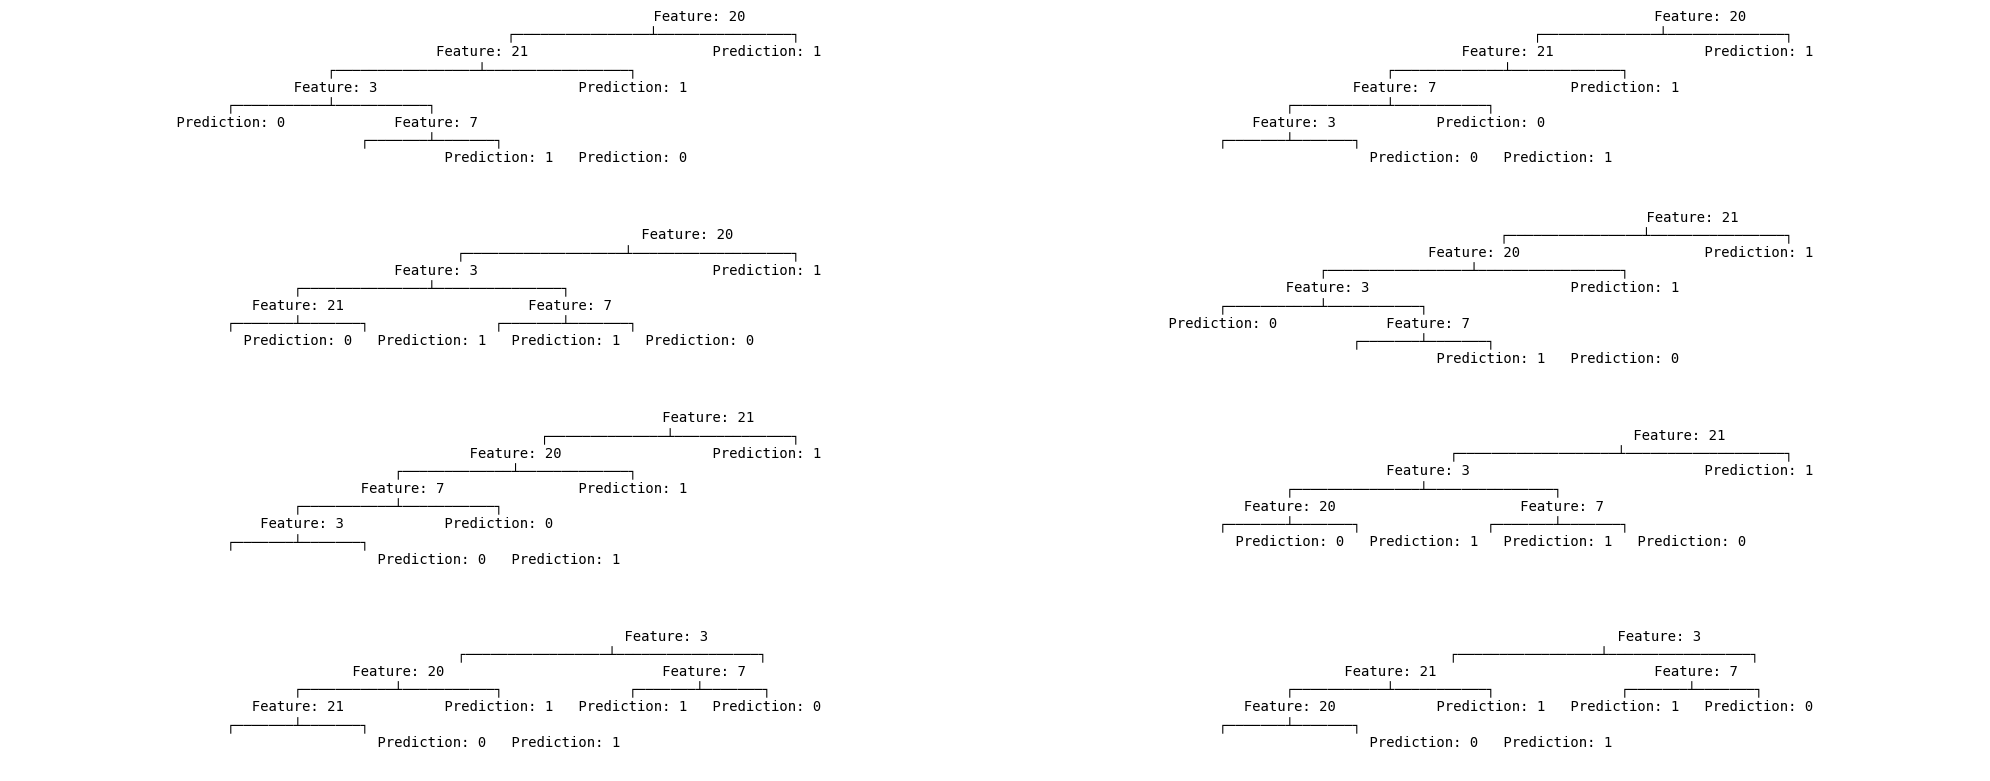

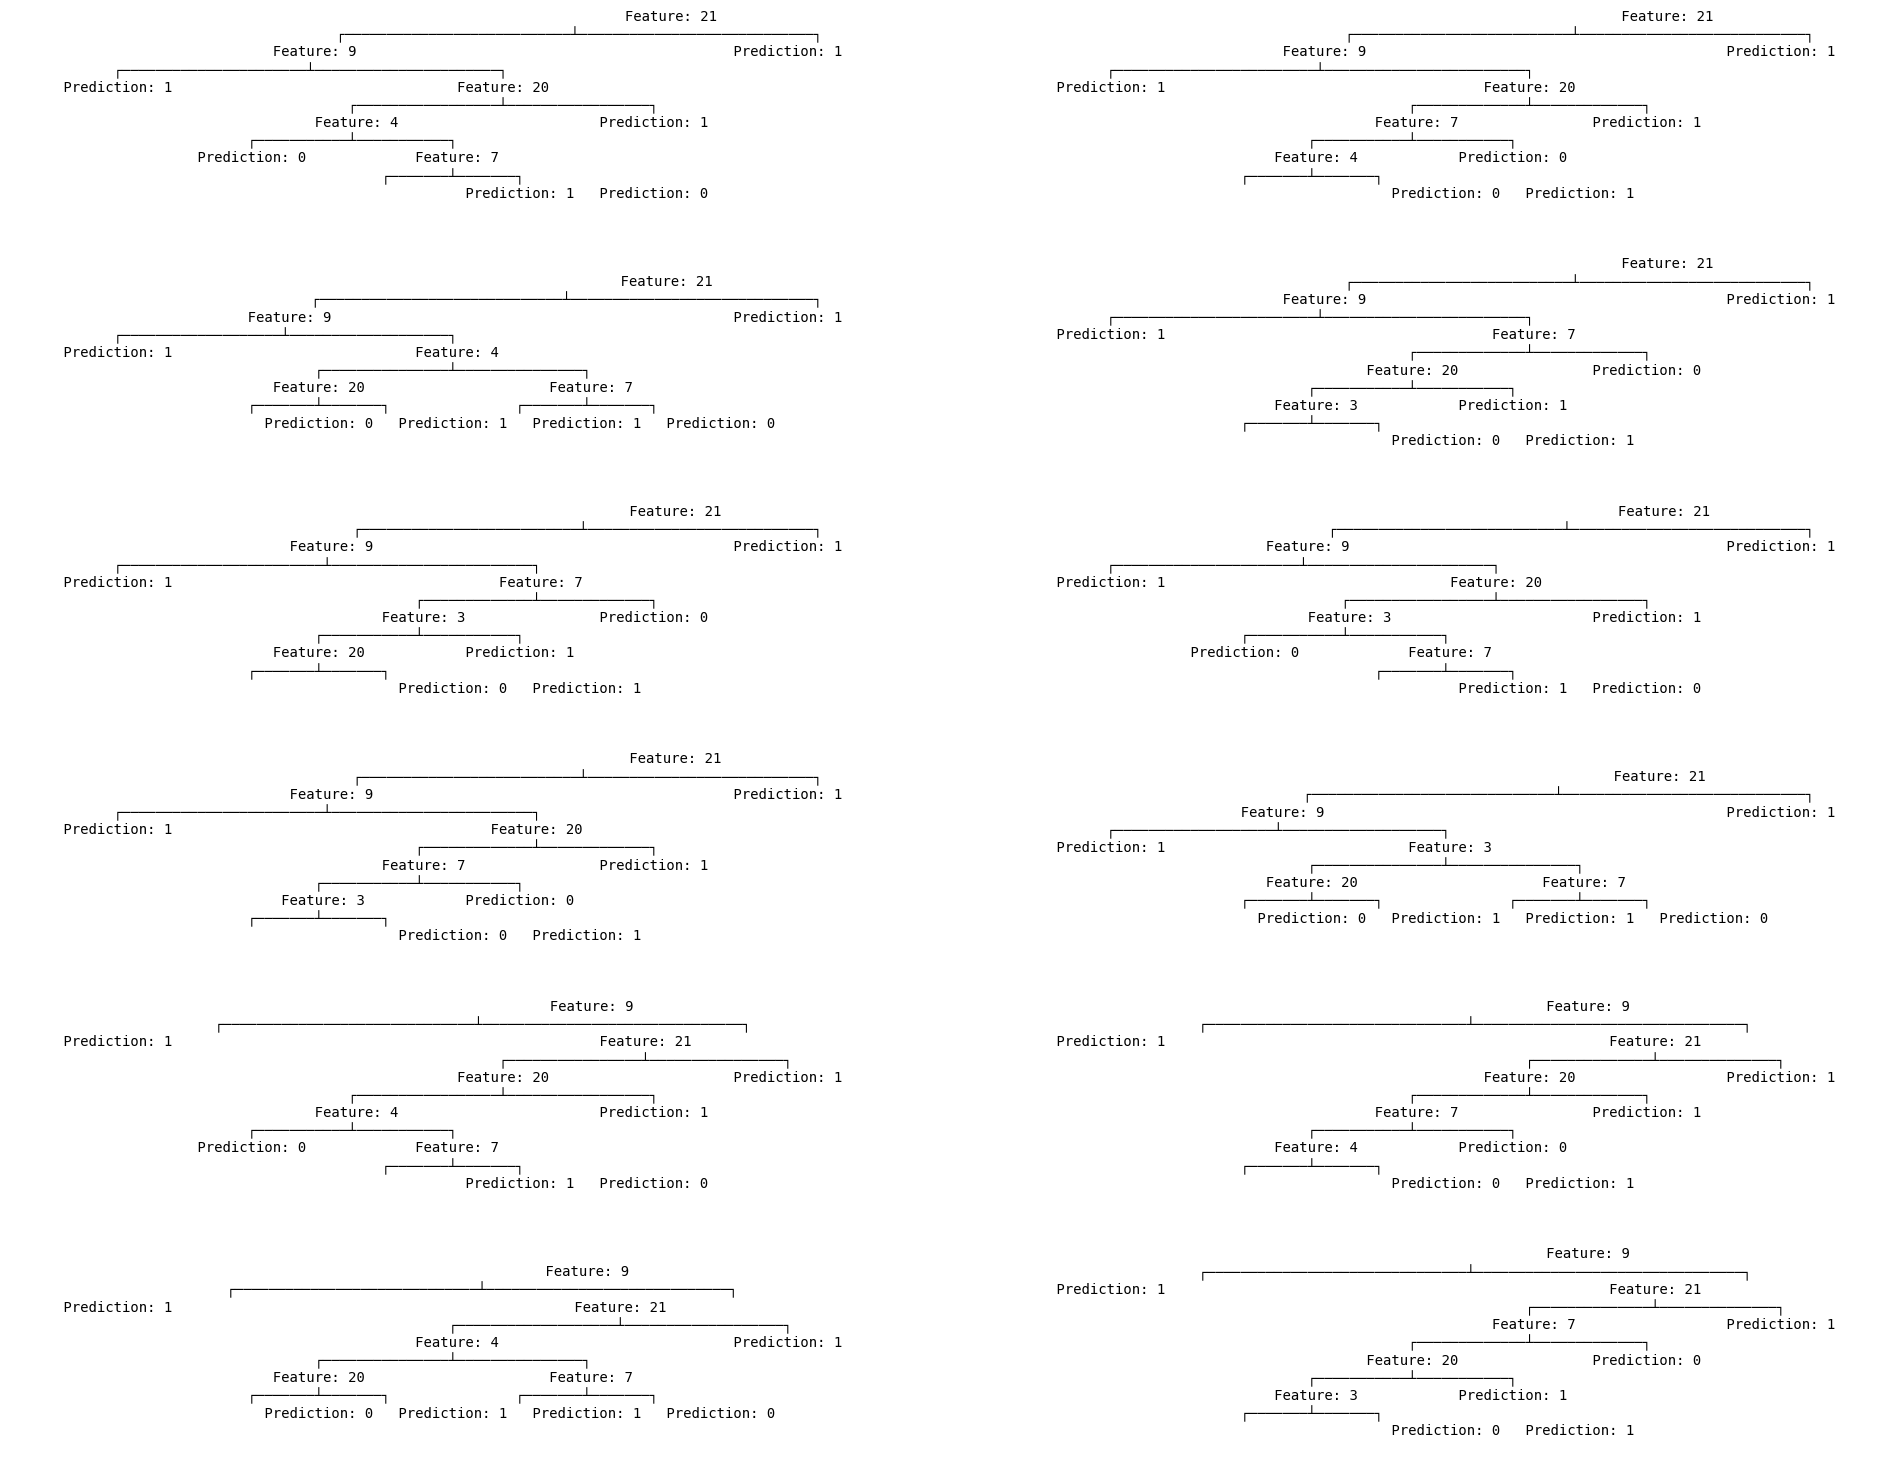

In [47]:

trees = []
for index in range(len(best_trees)):
    tree = _tree_to_dict(best_trees[index], [
        0, 1]).copy()
    tree = json_to_tree(tree)
    tree_preds = np.array([model._predict_sample(
        X.values[i, :], best_trees[index])for i in range(X.shape[0])])
    tree_leaves = get_num_leaves_greedy(best_trees[index])
    loss = (y != tree_preds).mean() + config['regularization']*tree_leaves
    print(loss)
    trees.append(tree)
plot_trees_in_subplots(trees[:8], rows=4, cols=2)

trees_lookahead = []
for index in range(len(best_trees_lookahead)):
    tree = _tree_to_dict(best_trees_lookahead[index], [
        0, 1]).copy()
    tree = json_to_tree(tree)
    tree_preds = np.array([model._predict_sample(
        X.values[i, :], best_trees_lookahead[index])for i in range(X.shape[0])])
    tree_leaves = get_num_leaves_greedy(best_trees_lookahead[index])
    loss = (y != tree_preds).mean() + config['regularization']*tree_leaves
    print(loss)
    # Increment the root feature to simulate variation
    # modified_tree["feature"] += i
    trees_lookahead.append(tree)
plot_trees_in_subplots(trees_lookahead[:12], rows=6, cols=2)

print(len(trees), len(trees_lookahead))

In [ ]:
for i in range(model.rashomon_set_prefix.get_tree_count()):
    tree_dict = vars(model.rashomon_set_prefix[i])['source']
    tree = model.dict_to_tree(tree_dict, X, y)
    if tree.feature == 6:
        tree_esp = tree_dict

In [ ]:
tree_esp

In [ ]:
for i in range(full_rashomon_set.get_tree_count()):
    tree_dict = vars(full_rashomon_set[i])['source']
    tree = model.dict_to_tree(tree_dict, X, y)

    if tree.feature == 6:
        tree_esp_full = tree_dict
        tree = _tree_to_dict(tree, [
            0, 1]).copy()
        tree = json_to_tree(tree)
        tree_preds = np.array([model._predict_sample(
            X.values[i, :], best_trees[index])for i in range(X.shape[0])])
        tree_leaves = get_num_leaves_greedy(best_trees[index])
        loss = (y != tree_preds).mean() + config['regularization']*tree_leaves
        print(loss)

In [ ]:
import json
text = '{"a": 1, "b": 2}'  # a string with json encoded data
data = json.loads(text)

In [ ]:
config = {
    "regularization": 0.005,
    "rashomon_bound_multiplier": 0.01,
    "depth_budget": 5,
    'cart_lookahead_depth': 2,
    "verbose": False
}
load_path = '{}_model_lookahead_3.pkl'.format('netherlands')
rashomon_set_prefix = pkl.load(open(load_path, 'rb'))['rset']

print(json.loads(rashomon_set_prefix.model))

TypeError: '<=' not supported between instances of 'int' and 'slice'